# ARIMA Modelling: Forecasting Weekly Hotel Cancellations

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pmdarima as pm

## Loading and prepare data

In [3]:
df = pd.read_csv('H1.csv')

In [4]:
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
df.dtypes

IsCanceled                       int64
LeadTime                         int64
ArrivalDateYear                  int64
ArrivalDateMonth                object
ArrivalDateWeekNumber            int64
ArrivalDateDayOfMonth            int64
StaysInWeekendNights             int64
StaysInWeekNights                int64
Adults                           int64
Children                         int64
Babies                           int64
Meal                            object
Country                         object
MarketSegment                   object
DistributionChannel             object
IsRepeatedGuest                  int64
PreviousCancellations            int64
PreviousBookingsNotCanceled      int64
ReservedRoomType                object
AssignedRoomType                object
BookingChanges                   int64
DepositType                     object
Agent                           object
Company                         object
DaysInWaitingList                int64
CustomerType             

In [6]:
for col in df.columns:
    type_ = df[col].dtype
    print(col, ' : ', type_, '\t')
    if type_ == 'object':
        print('Number of uniqe values: ', df[col].nunique(), ', Uniqe values: ' , df[col].unique())
        

IsCanceled  :  int64 	
LeadTime  :  int64 	
ArrivalDateYear  :  int64 	
ArrivalDateMonth  :  object 	
Number of uniqe values:  12 , Uniqe values:  ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
ArrivalDateWeekNumber  :  int64 	
ArrivalDateDayOfMonth  :  int64 	
StaysInWeekendNights  :  int64 	
StaysInWeekNights  :  int64 	
Adults  :  int64 	
Children  :  int64 	
Babies  :  int64 	
Meal  :  object 	
Number of uniqe values:  5 , Uniqe values:  ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'Undefined']
Country  :  object 	
Number of uniqe values:  125 , Uniqe values:  ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JA

In [7]:
data_types = {c:'category' for c in df.columns if df[c].dtype=='object'}
data_types

{'ArrivalDateMonth': 'category',
 'Meal': 'category',
 'Country': 'category',
 'MarketSegment': 'category',
 'DistributionChannel': 'category',
 'ReservedRoomType': 'category',
 'AssignedRoomType': 'category',
 'DepositType': 'category',
 'Agent': 'category',
 'Company': 'category',
 'CustomerType': 'category',
 'ReservationStatus': 'category',
 'ReservationStatusDate': 'category'}

In [8]:
df = df.astype(data_types)

In [9]:
df.dtypes

IsCanceled                        int64
LeadTime                          int64
ArrivalDateYear                   int64
ArrivalDateMonth               category
ArrivalDateWeekNumber             int64
ArrivalDateDayOfMonth             int64
StaysInWeekendNights              int64
StaysInWeekNights                 int64
Adults                            int64
Children                          int64
Babies                            int64
Meal                           category
Country                        category
MarketSegment                  category
DistributionChannel            category
IsRepeatedGuest                   int64
PreviousCancellations             int64
PreviousBookingsNotCanceled       int64
ReservedRoomType               category
AssignedRoomType               category
BookingChanges                    int64
DepositType                    category
Agent                          category
Company                        category
DaysInWaitingList                 int64


In [62]:
df['YearWeek'] = df['ArrivalDateYear'].map(str) + '-W' +df['ArrivalDateWeekNumber'].map(str)

In [63]:
df.sort_values(by='YearWeek', ascending=True)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,YearWeek
0,0,342,2015,July,27,1,0,0,2,0,...,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-W27
114,1,101,2015,July,27,4,2,6,2,0,...,240,NULL,0,Transient,96.30,0,1,Canceled,2015-05-12,2015-W27
115,0,109,2015,July,27,4,2,6,2,0,...,240,NULL,0,Transient,123.00,0,1,Check-Out,2015-07-12,2015-W27
116,0,92,2015,July,27,4,4,6,2,0,...,40,NULL,0,Contract,71.55,0,1,Check-Out,2015-07-14,2015-W27
117,0,92,2015,July,27,4,4,6,2,0,...,40,NULL,0,Contract,71.55,0,1,Check-Out,2015-07-14,2015-W27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33774,0,7,2017,March,9,2,0,1,1,0,...,NULL,331,0,Transient,54.00,0,0,Check-Out,2017-03-03,2017-W9
33777,0,16,2017,March,9,2,0,1,2,1,...,240,NULL,0,Transient,100.00,1,2,Check-Out,2017-03-03,2017-W9
33778,0,1,2017,March,9,2,0,1,1,0,...,NULL,NULL,0,Transient-Party,68.00,0,0,Check-Out,2017-03-03,2017-W9
33757,0,1,2017,March,9,1,0,1,2,2,...,240,NULL,0,Transient,93.00,0,0,Check-Out,2017-03-02,2017-W9


In [69]:
df['week'] = pd.to_datetime(df['YearWeek'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y-W%W-%w")))

In [73]:
cancelled_per_week = df.groupby('week').apply(lambda x: sum(x['IsCanceled']))
cancelled_per_week

week
2015-07-06     41
2015-07-13     48
2015-07-20     87
2015-07-27     74
2015-08-03    101
             ... 
2017-07-31    173
2017-08-07    140
2017-08-14    182
2017-08-21    143
2017-08-28    100
Length: 113, dtype: int64

In [85]:
tseries = pd.DataFrame(cancelled_per_week)
tseries.index

DatetimeIndex(['2015-07-06', '2015-07-13', '2015-07-20', '2015-07-27',
               '2015-08-03', '2015-08-10', '2015-08-17', '2015-08-24',
               '2015-08-31', '2015-09-07',
               ...
               '2017-06-26', '2017-07-03', '2017-07-10', '2017-07-17',
               '2017-07-24', '2017-07-31', '2017-08-07', '2017-08-14',
               '2017-08-21', '2017-08-28'],
              dtype='datetime64[ns]', name='week', length=113, freq=None)

<AxesSubplot:xlabel='week'>

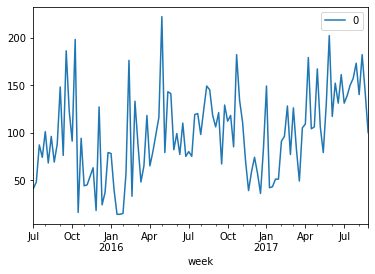

In [86]:
tseries.plot()

## Time Series Decompositions

In [87]:
decomposition = seasonal_decompose(tseries, period=52)
residual = decomposition.resid
trend = decomposition.trend
seasonal = decomposition.seasonal

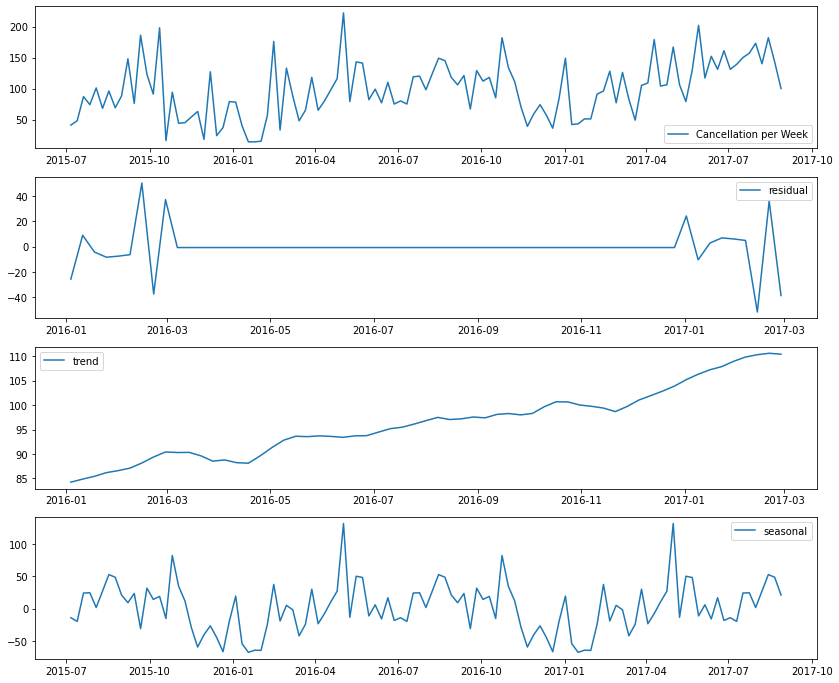

In [89]:
# Create just a figure and only one subplot
# Create two subplots and unpack the output array immediately
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.set_size_inches(14, 12)

ax1.plot(tseries)
ax1.legend(['Cancellation per Week'])

ax2.plot(residual)
ax2.legend(['residual'])

ax3.plot(trend)
ax3.legend(['trend'])

ax4.plot(seasonal)
ax4.legend(['seasonal'])

# Share a X axis with each column of subplots
# plt.subplots(2, 2, sharex='col')

### Autocorrelation and Partial Autocorrelation Plots

In [90]:
acf(tseries, nlags=100)

/Users/amir/anaconda3/envs/py3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


array([ 1.00000000e+00,  3.14949027e-01,  3.74204901e-01,  3.40446079e-01,
        1.85556507e-01,  2.13136161e-01,  1.30956891e-01,  1.70735372e-01,
        1.96370827e-01,  1.66930618e-01,  1.08698106e-01,  9.24599229e-02,
        6.29451510e-02, -2.82606089e-02, -4.09021428e-03, -6.31854967e-02,
        7.69288942e-03, -1.23231247e-01,  2.42349114e-03, -1.51584898e-01,
       -8.42025481e-02, -5.64434651e-03, -1.48420810e-01,  5.22824206e-02,
       -4.54132071e-02, -8.19718526e-02, -5.91062375e-02, -8.97179423e-02,
       -1.32884690e-01, -1.11016112e-01, -8.40764447e-02, -1.14007969e-01,
       -4.38309807e-03, -4.72991975e-02, -3.30634789e-03, -3.59136001e-02,
       -2.97156095e-02, -2.74543417e-02, -1.11358698e-01, -5.81596054e-02,
       -1.63978653e-02, -1.45729734e-02,  4.72859182e-02,  2.30771160e-02,
        1.00509157e-01,  4.78037703e-02,  1.41431782e-01,  6.79022156e-02,
        8.67828613e-02,  1.30237321e-01,  9.71189786e-02,  9.87925133e-02,
        1.53018437e-01,  

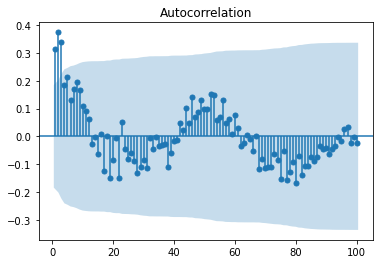

In [91]:
plot_acf(tseries, lags=100, zero=False);

In the autocorrelation plot above, the strongest correlation after the period of negatively correlated lags occurs at t=51. In this regard, **m=51** is chosen as the seasonal parameter in the ARIMA model.

This resource provides some useful information in explaining how the seasonality cycle is determined using the autocorrelation function: [Oracle Crystal Ball Predictor User's Guide: Identifying Seasonality with Autocorrelations](https://docs.oracle.com/cd/E57185_01/CBPUG/PRHistData_Autocorr.htm)

In [98]:
pacf(tseries, nlags=30)

array([ 1.        ,  0.31776107,  0.31141996,  0.20622471, -0.03688531,
        0.03378328, -0.01977916,  0.08375885,  0.11598273,  0.05836388,
       -0.0739093 , -0.05579603, -0.02911763, -0.10614344, -0.02213455,
       -0.0682831 ,  0.06240186, -0.16789808,  0.09161528, -0.19087933,
        0.03212692,  0.12896496, -0.06534606,  0.17895907, -0.02584965,
       -0.0965245 , -0.09419823,  0.01988623, -0.12777817, -0.00626335,
       -0.00766725])

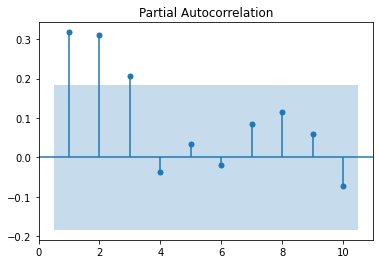

In [103]:
plot_pacf(tseries, lags=10, zero=False);